In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
from photutils import RectangularAperture, aperture_photometry
import glob, pdb, mpld3, batman
from mpld3 import plugins
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = (12, 6)
mpld3.enable_notebook()

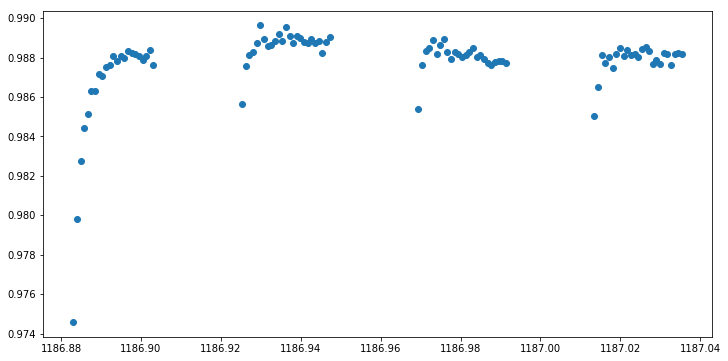

In [2]:
data       = ascii.read('lc_info.csv')
norm_flux  = data['res_flux']/np.median(data['res_flux'])

# Calculating time and orbital phase
transit_cen = 2454159.45320
period      = 1.5089557
jd_const    = 2400000.5
time_jd     = data['time'] + jd_const
orbitalP    = np.sort((time_jd - transit_cen)/period)

plt.plot(orbitalP[98:196], norm_flux[98:196], 'o')

In [3]:
# Exponential model
def exp(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val

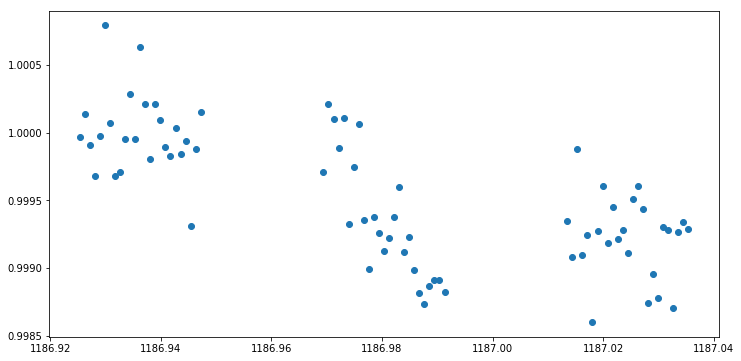

In [4]:
op22     = orbitalP[121:146]
flux22   = norm_flux[121:146]
param, _ = curve_fit(exp, op22-op22[0], flux22, p0=(1, (1.5*24*60)/10, 0))

f_v2o2 = norm_flux[121:146]/exp(orbitalP[121:146] - orbitalP[121], *param)
f_v2o3 = norm_flux[146:171]/exp(orbitalP[146:171] - orbitalP[146], *param)
f_v2o4 = norm_flux[171:196]/exp(orbitalP[171:196] - orbitalP[171], *param)

f_v2 = np.concatenate((f_v2o2,f_v2o3,f_v2o4))
plt.plot(orbitalP[121:196], f_v2, 'o', label = 'exponential fitted original data')

In [5]:
wavelength = np.load('wavelength.npy')/10e3

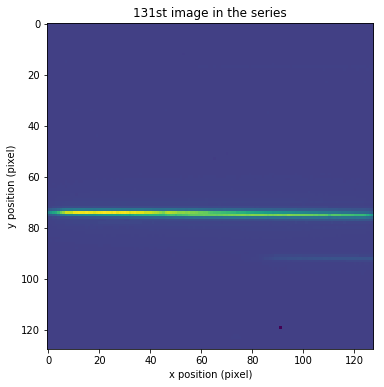

In [6]:
fnames = ascii.read('filenames.csv')
hdu    = fits.open(fnames[130][0])
image  = hdu[1].data
plt.imshow(image)
plt.xlabel('x position (pixel)')
plt.ylabel('y position (pixel)')
plt.title('131st image in the series')
plt.savefig('spec_image.pdf')

In [7]:
image[70:80, 5]

array([  12.98309898,   13.56534863,   36.96244812,  174.38783264,
        585.44238281,  196.26342773,   36.23202515,   14.88569069,
         14.16679764,    9.29651833], dtype=float32)

In [8]:
flux = np.array([np.sum(image[70:80, i]) for i in range(image.shape[1])])

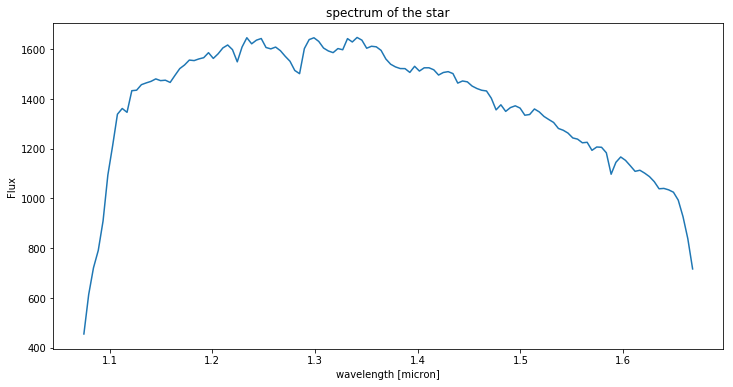

In [9]:
plt.plot(wavelength, flux)
plt.xlabel('wavelength [micron]')
plt.ylabel('Flux')
plt.title('spectrum of the star')
plt.savefig('star.pdf')

In [10]:
grism_hdu = fits.open('../WFC3.IR.G141.1st.sens.2.fits')

In [11]:
grism_hdu[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.7a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   12 /Number of bytes per row                         
NAXIS2  =                 7751 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    3 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [12]:
grism_data = grism_hdu[1].data
gTable = Table(grism_data)
gTable

WAVELENGTH,SENSITIVITY,ERROR
float32,float32,float32
9950.0,0.0,0.0
9951.0,0.0,0.0
9952.0,0.0,0.0
9953.0,2.82387e+13,1.61591e+13
9954.0,2.84663e+13,1.63873e+13
9955.0,2.86952e+13,1.6618e+13
9956.0,2.89254e+13,1.68509e+13
9957.0,2.91569e+13,1.70862e+13
9958.0,2.93898e+13,1.73239e+13


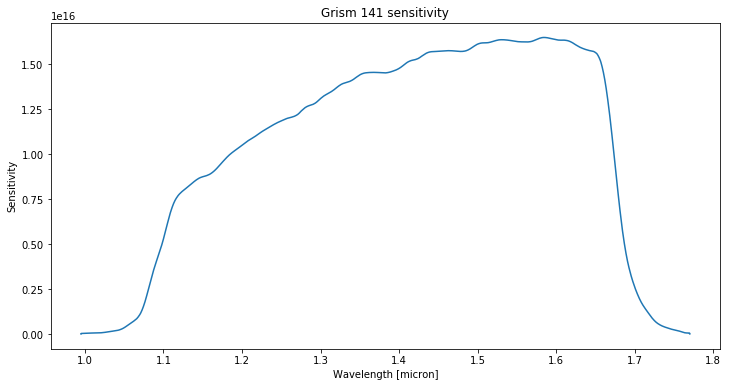

In [13]:
gWave = gTable['WAVELENGTH']/10e3
gSens = gTable['SENSITIVITY'] 
plt.plot(gWave, gSens)
plt.title('Grism 141 sensitivity')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Sensitivity')
plt.savefig('grism.pdf')

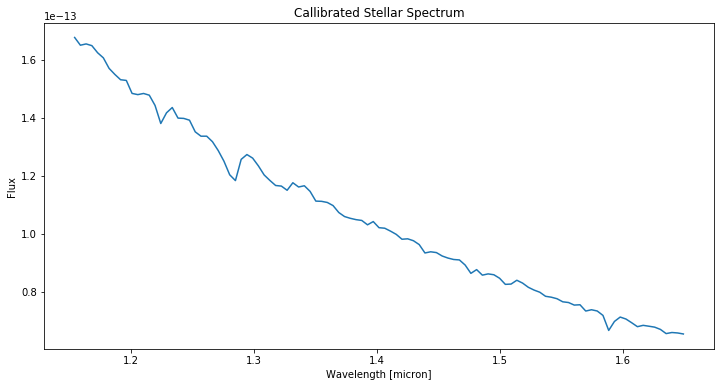

In [14]:
ind = np.where((wavelength>1.15) & (wavelength<1.65))
f = interp1d(gWave, gSens)
intrpd_gSens = f(wavelength)
plt.plot(wavelength[ind], flux[ind]/intrpd_gSens[ind])
plt.xlabel('Wavelength [micron]')
plt.ylabel('Flux')
plt.title('Callibrated Stellar Spectrum')
plt.savefig('cal_star.pdf')

In [15]:
h = 6.62*10e-35      #planck constant
c = 3*10e7           #speed of light
k = 1.38*10e-24      #boltzmann constant
def planck(wave, temp, const):
    waveMeters = wave*10**(-6)
    t1  = 8*np.pi*h*c
    t2  = waveMeters**5
    t3  = (h*c)/(waveMeters*k*temp)
    val = t1/(t2*(np.exp(t3)-1.0)*const)
    return val

In [16]:
trimmed_wave = wavelength[ind]
norm_stellar_flux = flux[ind]/np.median(flux[ind])
norm_grism_sens = intrpd_gSens[ind]/np.median(intrpd_gSens[ind])
callibrated_flux = norm_stellar_flux/norm_grism_sens
planck_param, _ = curve_fit(planck, trimmed_wave, callibrated_flux, p0=(9000, 1e-19))
planck_param

array([   5165.76248075,  146915.8499225 ])

In [17]:
trimmed_wave[np.argmax(planck(trimmed_wave, planck_param[0], planck_param[1]))]

NameError: name 'wl' is not defined

In [ ]:
mpld3.disable_notebook()

In [ ]:
temp = np.linspace(5000, 9000, 5)
wl = np.linspace(0.15, 1.9, 1000)
planck_param, _ = curve_fit(planck, trimmed_wave, callibrated_flux, p0=(5000, 1e-19))
print(planck_param)
plt.plot(wl, planck(wl, planck_param[0], planck_param[1]), '--', label='Planck function')
plt.plot(trimmed_wave, callibrated_flux, label = 'Stellar spectrum')
plt.axhline(y=np.max(planck(wl, planck_param[0], planck_param[1])), linewidth = 0.5, color = 'k')
lambda_p = wl[np.argmax(planck(wl, planck_param[0], planck_param[1]))]
plt.axvline(x= lambda_p, linewidth = 0.5, color = 'k')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Intensity')
plt.title('Fitting planck function to stellar spectrum')
plt.legend(loc = 'best')
plt.annotate(r'$\lambda=%f \mu m$' % lambda_p, xy=(0.6, 1.5), xytext=(0.75, 1.5), 
             arrowprops=dict(facecolor='black', shrink=0.01),)
plt.savefig('planck.pdf')